In [1]:
import sys
import os
# Get current directory
current_dir = os.getcwd()
# Get parent directory
parent_dir = os.path.join(current_dir, '..')
# Append parent directory to sys.path
sys.path.append(parent_dir)



In [2]:
from wordcloud import WordCloud
import pandas as pd
import os
import pathlib
import gensim
import pyLDAvis
import pyLDAvis.gensim
from gensim import models,corpora
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from src.aspect_classification.data.data_cleaning import gensim_processing
from scipy.sparse import csr_matrix
from dotenv import load_dotenv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [5]:
homepath = os.getenv('LOCAL_ENV')
# /Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/data/processed/aspect_classification_data/euans_reviews.csv
euans_path = homepath + 'data/processed/aspect_classification_data/euans_reviews.csv'
google_path = homepath + 'data/processed/aspect_classification_data/google_reviews.csv'
euans_data = pd.read_csv(euans_path)
google_data = pd.read_csv(google_path)

# Exploratory Data Analysis

### Firstly, I have created some visualisations linked to the Euans Guide data that will be used for training to understand the propotions of the features that we will be focusing on in the pipeline.


In [ ]:
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3, contour_color='steeleblue')
clustered_reviews_train = ','.join(list(euans_data['Text'].values))
train_wc = wordcloud.generate(clustered_reviews_train)
train_wc.to_file(homepath + "reports/figures/euans_word_cloud.png")

In [7]:
amount_per_aspect = euans_data.groupby(['Aspect']).count()
amount_per_aspect = amount_per_aspect['Text']

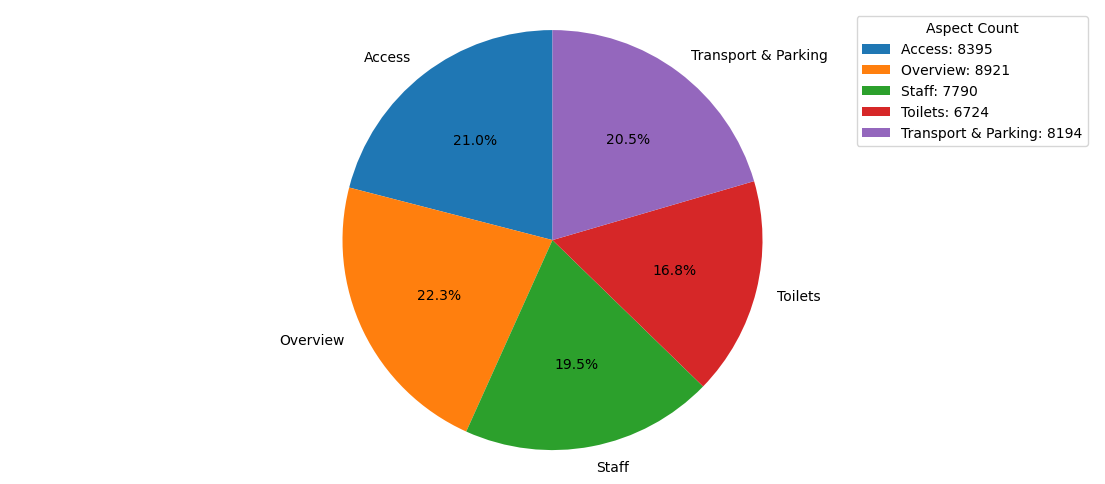

In [8]:
# Create a pie chart of the aspect counts
fig, ax = plt.subplots(figsize=(14, 6))
labels = amount_per_aspect.index
sizes = amount_per_aspect.values
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Add a legend with the aspect counts
legend_labels = [f"{label}: {size}" for label, size in zip(labels, sizes)]
ax.legend(legend_labels, title="Aspect Count", loc="best")

# Set the file path to save the plot to
aspects_file_path = homepath + "reports/figures/euans_aspects_amounts_piechart_with_stats.png"

# Save the plot to the file path
plt.savefig(aspects_file_path, bbox_inches='tight')

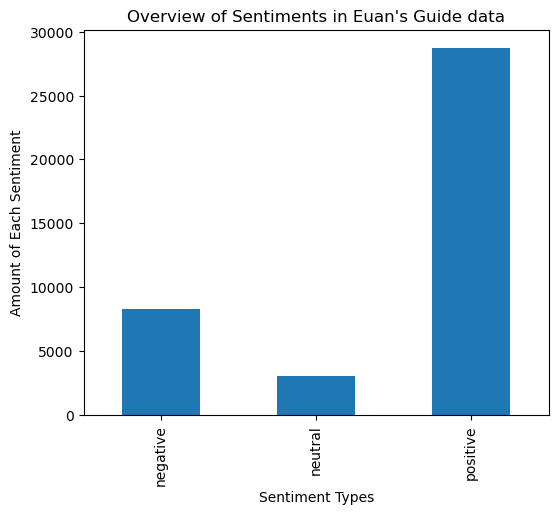

In [9]:
amount_per_sentiment = euans_data.groupby(['Sentiment']).count()
amount_per_sentiment = amount_per_sentiment['Text']
plot = amount_per_sentiment.plot(kind='bar', title="Overview of Sentiments in Euan's Guide data", ylabel='Amount of Each Sentiment', xlabel='Sentiment Types', figsize=(6,5))

# Set the file path to save the plot to
sentiment_file_path = cwd.joinpath("reports/figures/euans_sentiment_count.png")

# Save the plot to the file path
plot.get_figure().savefig(sentiment_file_path)


#### Next, I will do some topic modelling with the Google Reviews data, because this data is not labelled in respect to the matching aspects in Euans Guide. 

#### This will help us investigate what common topics exist in this data so that when I perform my labelling experiment. I know what categories are over-represented and under-represented in my sample.

In [10]:
tokenised_google_reviews = google_data['Text'].apply(gensim_processing)

dictionary = gensim.corpora.Dictionary(tokenised_google_reviews)

In [11]:
# Filter the dictionary to remove rare and common tokens
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [12]:
google_corpus = [dictionary.doc2bow(review) for review in tokenised_google_reviews]
# Load environment variables from .env file
load_dotenv()


True

In [13]:
print(google_corpus[:2])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1)], [(0, 2), (5, 1), (10, 1), (13, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]]


In [14]:
model_folder_path = os.environ.get('TFIDF_LDA_MODEL_PATH')
tfidf_model_path = model_folder_path + '/lda_tfidf.lda'
print(tfidf_model_path)
loaded_model = LdaModel.load(tfidf_model_path)

/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/models/aspect_classification/eda/lda_tfidf.lda


In [15]:
# create a bag-of-words representation of the new documents
new_corpus = [loaded_model.id2word.doc2bow(doc) for doc in tokenised_google_reviews]

# get the topic distribution for each new document
new_doc_topics = [loaded_model.get_document_topics(doc) for doc in new_corpus]

In [16]:
from sklearn.manifold import TSNE
# create a matrix of the topic distributions

doc_topic_matrix = csr_matrix((len(new_doc_topics), loaded_model.num_topics))
doc_topic_matrix_dense = doc_topic_matrix.toarray()
for i, doc_topics in enumerate(new_doc_topics):
    for topic, prob in doc_topics:
        doc_topic_matrix_dense[i, topic] = prob

# reduce the dimensionality of the matrix using PCA
# pca = PCA(n_components=2)
# doc_topic_matrix_reduced = pca.fit_transform(doc_topic_matrix_dense)

tsne = TSNE(n_components=2, random_state=42)
doc_topic_matrix_reduced = tsne.fit_transform(doc_topic_matrix_dense)

# cluster the documents using K-Means clustering
from sklearn.cluster import KMeans
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
doc_clusters = kmeans.fit_predict(doc_topic_matrix_reduced)



/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


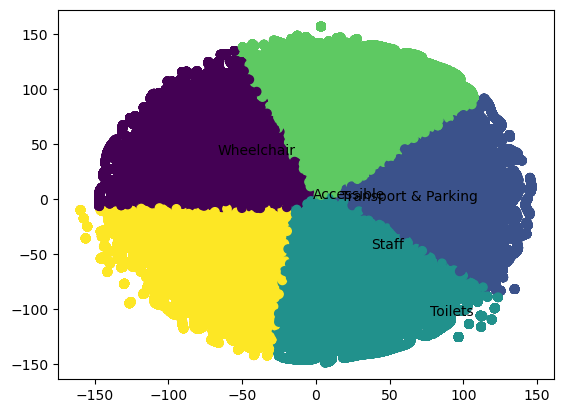

In [17]:
# Choose a different plot and check pre-processing with gensim
topic_labels = ['Toilets', 'Transport & Parking', 'Staff', 'Accessible', 'Wheelchair']
plt.scatter(doc_topic_matrix_reduced[:, 0], doc_topic_matrix_reduced[:, 1], c=doc_clusters)
for i, txt in enumerate(topic_labels):
    plt.annotate(txt, (doc_topic_matrix_reduced[i, 0], doc_topic_matrix_reduced[i, 1]))
plt.show()

In [18]:
import top2vec

/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-09 14:21:20.083016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


do the cohens kappa thing